## **Python for Quantitative Trading: Futures**
### **Integrated CTA Strategies Episode 1 - Basic Data Analysis**

In [13]:
# -*- coding: utf-8 -*-
"""
Created on Sat July 12 15:28:01 2021

@author: Bradley

Slides for practicing CTA Strategies
"""

'\nCreated on Sat July 12 15:28:01 2021\n\n@author: Bradley\n\nSlides for practicing CTA Strategies\n'

In [14]:
import numpy as np
import pandas as pd
import math
import gzip
import _pickle as cPickle
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime

import functools
import os
from multiprocessing import pool, cpu_count


plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签`
plt.rcParams['axes.unicode_minus'] = False

%config InlineBackend.figure_format = 'svg' #在notebook中可以更好的显示，svg输出是一种向量化格式，缩放网页并不会导致图片失真。这行代码似乎只用在ipynb文件中才能使用。

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')  # 忽略一些warnings

# This allows multiple outputs from a single jupyter notebook cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('expand_frame_repr', False)  
pd.set_option("display.max_rows", 500) 
pd.set_option('display.max_columns', None) #防止column太多中间变成省略号


In [4]:
from multiprocessing import pool, cpu_count
cpu_count()

96

In [3]:
import os
os.getcwd()

'/home/yby/SGD-HFT-Intern/Projects/CTA/src'

In [ ]:
# global settings
HEAD_PATH = "/home/yby/SGD-HFT-Intern/Projects/CTA"
DATA_PATH = HEAD_PATH
SAVE_PATH = HEAD_PATH + "/result"
SIGNAL_PATH = HEAD_PATH
CORE_NUM = 48

In [1]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


#### 查看数据范围

In [16]:
product_list = ["rb", "hc", "i", "j", "jm"]
product = product_list[0] #可以自行修改品种，然后重新跑下面所有的程序
dire = DATA_PATH + '\\'+ product #某个品种数据对应的路径
all_dates = list(map(lambda x: x,os.listdir(dire))) #对应数据集的所有文件名的list集合
len(all_dates) #一共1067条数据
all_dates[:3]
all_dates[-3:]

1067

['20170103.pkl', '20170104.pkl', '20170105.pkl']

['20210521.pkl', '20210524.pkl', '20210525.pkl']

读取一个具体的数据文件，以某一天的tick数据作为示范

In [17]:
date = "20210519"
directory = dire+'\\'+date+'.pkl'
# rb是二进制的格式读取文件，文件必须已存在
with gzip.open(dire+"\\"+date+".pkl", 'rb', compresslevel=1) as file_object:
    raw_data = file_object.read()
data = cPickle.loads(raw_data)
data

,contract,date.time,price,cum.open.int,open.int,turnover,qty,bid,ask,bid.qty,ask.qty,date,time,milli,good,mid.price,buy.trade,buy2.trade,sell.trade,sell2.trade,log.price,ret,wpr,wpr.ret,next.ask,next.bid,min.1024,max.1024,min.2048,max.2048,min.4096,max.4096
0,rb2110,2021-05-18 20:59:00.500,5599.0,1176544,2519,169929650.0,3035,5599.0,5600.0,46,252,20210518,20:59:00,0,False,5599.5,0.0,0.0,0.0,0.0,8.630371,0.000000,5599.154362,0.000000,5598.0,5597.0,5599.154362,5599.154362,5599.154362,5599.154362,5599.154362,5599.154362
1,rb2110,2021-05-18 21:00:00.500,5598.0,1176978,434,45237810.0,808,5597.0,5598.0,172,1,20210518,21:00:00,0,False,5597.5,0.0,0.0,597.0,211.0,8.630164,-0.000207,5597.994220,-1.160143,5597.0,5595.0,5597.994220,5599.154362,5597.994220,5599.154362,5597.994220,5599.154362
2,rb2110,2021-05-18 21:00:01.000,5595.0,1177230,252,60275140.0,1077,5595.0,5597.0,50,246,20210518,21:00:01,0,False,5596.0,0.0,0.0,622.0,455.0,8.629689,-0.000475,5595.337838,-2.656382,5595.0,5594.0,5595.337838,5599.154362,5595.337838,5599.154362,5595.337838,5599.154362
3,rb2110,2021-05-18 21:00:01.500,5595.0,1177173,-57,33121430.0,592,5594.0,5595.0,28,261,20210518,21:00:01,0,False,5594.5,0.0,0.0,495.0,97.0,8.629467,-0.000222,5594.096886,-1.240952,5594.0,5593.0,5594.096886,5599.154362,5594.096886,5599.154362,5594.096886,5599.154362
4,rb2110,2021-05-18 21:00:02.000,5594.0,1177146,-27,30488910.0,545,5593.0,5594.0,96,120,20210518,21:00:02,0,False,5593.5,161.0,0.0,384.0,0.0,8.629351,-0.000117,5593.444444,-0.652441,5593.0,5592.0,5593.444444,5599.154362,5593.444444,5599.154362,5593.444444,5599.154362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82740,rb2110,2021-05-20 14:59:58.500,5184.0,1162249,-122,8502050.0,164,5184.0,5186.0,16,143,20210520,14:59:58,0,False,5185.0,29.0,0.0,135.0,0.0,8.553371,-0.000133,5184.201258,-0.691824,5187.0,5186.0,5170.913767,5199.064579,5170.913767,5227.232558,5170.913767,5229.810345
82741,rb2110,2021-05-20 14:59:59.000,5186.0,1162113,-136,8660570.0,167,5186.0,5187.0,138,80,20210520,14:59:59,0,False,5186.5,162.0,0.0,5.0,0.0,8.553840,0.000469,5186.633028,2.431770,5187.0,5186.0,5170.913767,5199.012000,5170.913767,5227.232558,5170.913767,5229.810345
82742,rb2110,2021-05-20 14:59:59.500,5187.0,1162047,-66,6638200.0,128,5186.0,5187.0,22,68,20210520,14:59:59,0,False,5186.5,12.0,0.0,116.0,0.0,8.553765,-0.000075,5186.244444,-0.388583,5187.0,5186.0,5170.913767,5198.441558,5170.913767,5227.232558,5170.913767,5229.810345
82743,rb2110,2021-05-20 15:00:00.000,5186.0,1162027,-20,2178150.0,42,5186.0,5187.0,15,74,20210520,15:00:00,0,False,5186.5,3.0,0.0,39.0,0.0,8.553750,-0.000015,5186.168539,-0.075905,5187.0,5186.0,5170.913767,5198.441558,5170.913767,5227.232558,5170.913767,5229.810345


- 关于上述column的解释：（注意，数据有很多都是自己估算的，因为交易所只公布了总的成交量，别的什么都没给，下面有些数据不全，因为从交易所获取的数据很有限，不同交易所提供特殊数据需要各种会员特权，一年二十万之类的）
- 注意这个数据是orderbook和trade的合体，buy.trade，buy2.trade，sell.trade，sell2.trade这种主动买卖量的数据都是从trade的1和-1的划分然后加起来的，非常珍贵的数据，尽管说是估算的

In [18]:
## contract: contract name, product+expiration date，合约名字+到期时间
## date.time: date and time，日期和时间，属于极高频的数据，tick级别的数据，精确到0.5秒
## price: newest price of data，最新的成交价
## cum.open.int: cumulative open interest，总持仓量
## open.int: newest open interest increment，最新的持仓量改变量
## turnover: newest turnover increment，最新的成交额(尽管这里写的是换手率，但实际是成交额)
## qty: newest trading volume，最新成交量
## bid: bid price，买一
## ask: ask price，卖一
## bid.qty: bid size，买一量
## ask.qty: ask size，卖一量
## date: actual date，实际日期
## time: actual time，实际时间
## milli: actual milli second，毫秒数（上期所与中金所是 000、500，大商所随机，郑商所是0）
## mid.price: middle price of bid and ask，买一和卖一的中间价
## buy.trade: active buy volume at level 1，一档主动买量（估算，非交易所提供）
## buy2.trade: active buy volume at other levels，其他价位主动买量（估算，非交易所提供）
## sell.trade: active sell volume at level 1，一档主动卖量（估算，非交易所提供）
## sell2.trade: active sell volume at other levels，其他价位主动卖量（估算，非交易所提供）
## log.price: log wpr (to be defined soon)，挂单量加权平均价的对数
## ret: log return of last tick，最新一笔行情的对数收益率（应该是用的wpr计算的）
## wpr: volume weighted price，挂单量加权平均价
## wpr.ret: price change of wpr，wpr的价格变化
## high: highest price of last ask, last price, and this ask，当前ask、前一个ask、最新价的最高价（构造最小级别K线用）
## low: lowest price of last bid, last price, and this bid，当前bid、前一个bid、最新价的最低价（构造最小级别K线用）
## next.bid: estimated active sell price, used for backtesting，主动卖单的成交价（自己shift的，算是未来信息），用于回测
## next.ask: estimated active buy price, used for backtesting，主动买单的成交价（自己shift的，算是未来信息），用于回测
## min.1024: rolling minimum of wpr over 1024 ticks，1024跳滚动最低价，即过去1024笔行情的wpr最小值
## max.1024: rolling maximum of wpr over 1024 ticks，1024跳滚动最高价
## min.2048: rolling minimum of wpr over 2048 ticks，2048跳滚动最低价
## max.2048: rolling maximum of wpr over 2048 ticks，2048跳滚动最高价
## min.4096: rolling minimum of wpr over 4096 ticks，4096跳滚动最低价
## max.4096: rolling maximum of wpr over 4096 ticks，4096跳滚动最高价

#### 画价格走势图，商品期货有夜盘，但不同品种交易时间也不尽相同

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Price')

Text(0.5, 1.0, 'Price change on 20210519')

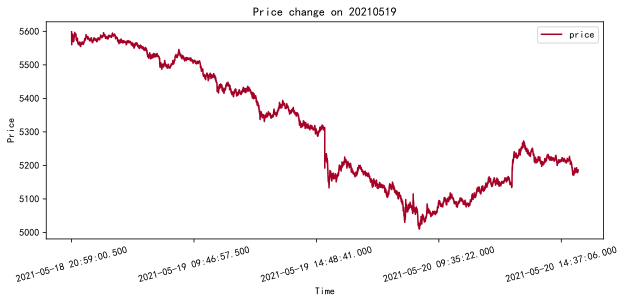

In [19]:
fig, ax = plt.subplots(figsize=(10,4))
data.plot(x='date.time', y="price", label='price', ax=ax, rot=15, colormap='RdYlBu')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.set_title('Price change on %s'%date)
ax.legend(loc='best')

#### 画更多的图出来

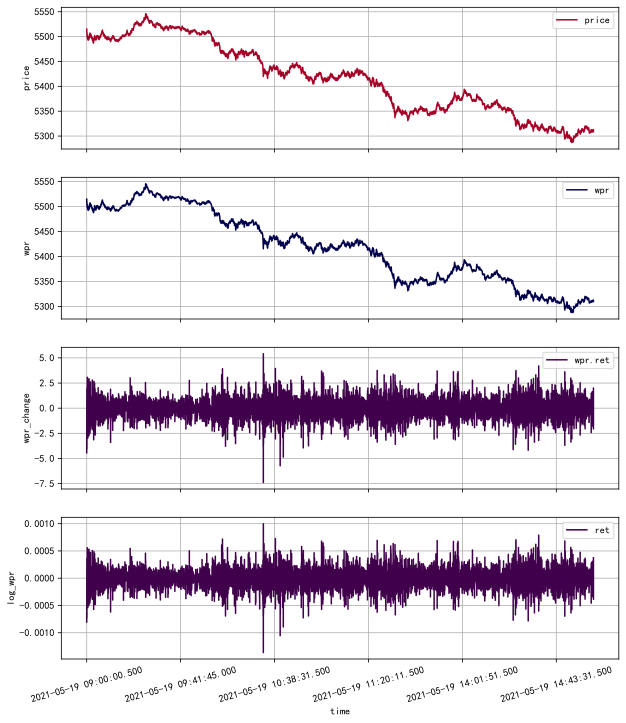

In [76]:
# 上图可以看到，每个数据集包含相邻三天的数据，第一天用于预热，防止一些因子值刚开始的数值不够稳定，第三天的数据用于作为回归的因变量，相当于未来数据
# 现在只画出当天的非夜盘的价格图，包括wpr的图，挂单量加权平均价，还有价格的变化ret，其中ret就相当于价格取diff函数，第一个的数值已经赋值为0了，看来这个pickle文件提前的处理已经很完善的。
# 相当于这个系列就是用已经处理好的数据进行策略构建了，之前繁琐的数据获取过程，爬虫，交易所接口等等包括数据的筛选清洗整理都已经完成了，那么与邢大的课程相比，邢大课程更加注重非策略的部分，策略部分构建的内容还很少，然而这个课程则是完全的策略部分，虽然可能只是一些简单的机器学习策略
range_ = (data["time"] >= "09:00:00") & (data["time"] < "15:00:02") & (data['date']==date)
fig, axes = plt.subplots(4, 1, figsize=(10,12), sharex=True)
# 成交价格图
axes[0] = data[range_].plot(x='date.time', y="price", xlabel='time', ylabel='price', kind='line', grid=True, colormap='RdYlBu',figsize=(10,12), legend=True, ax=axes[0], rot=15)
# wpr图，挂单量加权平均价
axes[1] = data[range_].plot(x='date.time', y="wpr", xlabel='time', ylabel='wpr', kind='line', grid=True, colormap='seismic',figsize=(10,12), legend=True, ax=axes[1], rot=15)
# wpr价格变化量图，wpr.ret
axes[2] = data[range_].plot(x='date.time', y="wpr.ret", xlabel='time', ylabel='wpr_change', kind='line', grid=True, colormap='PRGn',figsize=(10,12), legend=True, ax=axes[2], rot=15)
# 挂单量加权平均价计算的对数收益率图，ret
axes[3] = data[range_].plot(x='date.time', y="ret", xlabel='time', ylabel='log_wpr', kind='line', grid=True, colormap='PRGn',figsize=(10,12), legend=True, ax=axes[3], rot=15)


#### 计算tick数据中有多少正/负收益率数据，当然也肯定有相邻tick之间价格不变的情况

In [85]:
print('rising ticks: ',sum(data['ret'] > 0)) 
print('falling ticks: ',sum(data['ret'] < 0))
print('stable ticks: ',sum(data['ret'] == 0)) 
print('total ticks: ', len(data))

rising ticks:  41129
falling ticks:  41365
stable ticks:  251
total ticks:  82745


#### WPR如何计算？？

In [10]:
data[data['bid.qty'] == 0]

,contract,date.time,price,cum.open.int,open.int,turnover,qty,bid,ask,bid.qty,ask.qty,date,time,milli,good,mid.price,buy.trade,buy2.trade,sell.trade,sell2.trade,log.price,ret,wpr,wpr.ret,next.ask,next.bid,min.1024,max.1024,min.2048,max.2048,min.4096,max.4096


In [87]:
# 说了这么多，为什么要用wpr，挂单量加权平均价？以及相应的计算公式是什么？
# wpr的目的是让我们更好的估算价格。实时价格，有时候并没有卖一、买一的加权价格来的有效
# 计算公式：（里面牵扯的有买一量，卖一量，买一价和卖一价，根据对应的成交量计算的一个加权平均
data2 = data[['wpr']]
data2['wpr2'] = (data["bid"]*data["ask.qty"]+data["ask"]*data["bid.qty"])/(data["bid.qty"]+data["ask.qty"])
# wpr本身和OBI一样，都属于非常典型的订单簿因子
# 为什么bid的price乘的是ask的size？因为我们要反应的实际价格，当bid size远高于ask size的时候，price理应上涨，WAP价格应该更靠近卖价，因此是交叉着的
# 还有一种特殊情况：如果买一量和卖一量都是0，此时加权平均出来是0，这显然不是我们想要的，此时就还取对应的实时价格
# 其实就是涨跌停。涨停则ask=0，跌停则bid=0
data2[(data["ask.qty"]==0) | (data["bid.qty"]==0)]['wpr2'] = data["price"]
data2
print(sum(abs(data2['wpr2'] - data2["wpr"]) > 0.00000001)) # 所给的数据已经处理过涨跌停的情况了
# babyquant还是牛逼，商品期货的涨跌停机制如此复杂，连股票里面的涨跌停，都要考虑ST股，还有科创板，实在太难弄，后来实盘干脆实时爬取。好家伙现在期货巨复杂的涨跌停机制，已经处理过了，这部分代码应该是不公开的，数据处理过程应该不公开……
# 如果没有处理过涨跌停，卖一，买一量会出现一些问题，计算的wpr也会不准确
# 其实这里判断涨跌停就直接把historical的bid或ask等于0的给删掉就ok了

,wpr,wpr2
0,5599.154362,5599.154362
1,5597.994220,5597.994220
2,5595.337838,5595.337838
3,5594.096886,5594.096886
4,5593.444444,5593.444444
...,...,...
82740,5184.201258,5184.201258
82741,5186.633028,5186.633028
82742,5186.244444,5186.244444
82743,5186.168539,5186.168539


0

可以看出，计算出来的WPR和原数据给的是一致的。

#### **下面随机抽样数据，检查回报率的时间序列平稳性**

In [93]:
# 每500ms取样一次，也就是原始的tick的对数收益率序列

# ADF检验
# from arch.unitroot import ADF
# print(ADF(data["ret"][data["good"]]).summary()) #使用good=True的部分，数据处理的时候，由于每个dataset包含三天数据，中间那一天才能拿来回测，前面是预热，后面是未来数据，因此专门用good一列来记录中间那一天用于回测的数据，也就是当天的早上9点开始到当天夜盘结束这段时间拿来回测
# print('-------------------------------------')

#或者使用statsmodels，第一个是t值，第二个是p值
import statsmodels.tsa.stattools as ts
# augmented Dickey Fuller Test，检验stationarity
print(ts.adfuller(data["ret"][data["good"]], maxlag=int(pow(len(data["ret"][data["good"]])-1,(1/3))), regression='ct', autolag=None))
print('-------------------------------------')

# 使用KPSS检验，p值小则为平稳
print(ts.kpss(data["ret"][data["good"]], regression='c', lags=int(3*math.sqrt(len(data["ret"][data["good"]]))/13)))
print('-------------------------------------')


(-35.53819207976799, 0.0, 34, 41344, {'1%': -3.9589889867375008, '5%': -3.4105961972373993, '10%': -3.1271125409962335})
-------------------------------------
(0.07915820857532145, 0.1, 46, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
-------------------------------------


True
82626 82745


14281   -0.003788
14401   -0.000887
14521   -0.000007
14641   -0.000921
14761    0.000325
14881    0.000258
15001    0.000752
15121    0.001364
15241   -0.001791
15361   -0.000697
15481    0.000190
15601    0.000407
15721   -0.000025
15841   -0.000730
15961    0.000016
16081    0.000694
16201    0.000874
16321    0.000196
16441    0.000782
16561   -0.000489
16681    0.001746
16801    0.001572
16921    0.001009
17041   -0.000952
17161    0.000136
17281    0.001297
17401    0.002229
17521   -0.001300
17641   -0.001098
17761   -0.000585
17881   -0.001106
18001    0.001080
18121   -0.000552
18241   -0.000892
18361   -0.001194
18481    0.001284
18601   -0.000912
18721    0.001172
18841   -0.000373
18961   -0.000181
19081    0.000241
19201   -0.000256
19321   -0.000284
19441    0.000035
19561   -0.000644
19681   -0.000351
19801   -0.000492
19921    0.000702
20041   -0.000260
20161   -0.000914
20281   -0.000252
20401    0.000530
20521    0.000136
20641    0.000027
20761    0.000085
20881   -0

(-6.724769752595214, 5.8685541689542916e-08, 7, 337, {'1%': -3.9858876182413634, '5%': -3.423598642683739, '10%': -3.134757548798489})
(0.0722606084085975, 0.1, 4, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


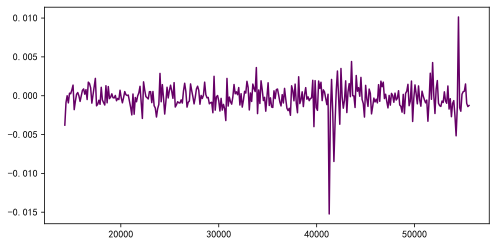

In [139]:
# 滚动120个tick（约1min）的数据，再检验平稳性
ret_120 = (data["ret"].rolling(120).sum()).dropna().reset_index(drop=True) #数据抽样

# 检验rolling数据正确性
print(sum(data["ret"][0:120]) == ret_120.iloc[0])

print(len(ret_120), len(data))

# 使用np.mod函数，每隔120个tick取一次
# 学到了，要我写肯定写不出来，mod函数写出取的range，然后iloc函数定位选取，不过为什么要切片？已经是good的部分了，也就是回测用的数据。因为即便是good的部分，rolling120也可能用到头一天的数据
range_120 = ((np.mod(np.arange(0, len(data)), 120)==0) & data["good"])[119:] 
ret_120.iloc[np.where(range_120)]

print(ts.adfuller(ret_120.iloc[np.where(range_120)], maxlag=int(pow(len(ret_120.iloc[np.where(range_120)])-1,(1/3))), regression='ct', autolag=None))

print(ts.kpss(ret_120.iloc[np.where(range_120)], regression='c', lags=int(3*math.sqrt(len(ret_120.iloc[np.where(range_120)]))/13)))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(ret_120.iloc[np.where(range_120)], color='#660066')

#### 可以看到，每隔120个tick取一次结果仍然是稳定的

In [95]:
# 滚动2000个tick，此时一天的数据量就不够了，只有20个
# 使用np.mod函数，每隔2000跳取一次
ret_2000 = (data["ret"].rolling(2000).sum()).dropna().reset_index(drop=True)
print(sum((np.mod(np.arange(1, len(data)+1),2000)==0) & (data["good"]))) 
# 满足条件的隔2000一个的，当天的，只有20个数据

20


In [101]:
# 数据量不够，需要load更多的数据检验平稳性
def load(path):
    with gzip.open(path, 'rb', compresslevel=1) as file_object:
        raw_data = file_object.read()
    return cPickle.loads(raw_data)

def get_sample_ret(date, period):
    data = load(DATA_PATH + '\\'+product+"\\"+date)
    ret = (data["ret"].rolling(period).sum()).dropna().reset_index(drop=True)
    range = ((np.mod(np.arange(0, len(data)),period)==0) & data["good"])[(period-1):]
    return ret.iloc[np.where(range)]

import functools
import dask
from dask import compute, delayed
def parLapply(CORE_NUM, iterable, func, *args, **kwargs):
    # 使用functools.partial接受固定部分的参数输入，剩余的部分参数在*args和**kwargs中传入func，f_par相当于func(*args, **kwargs)
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(func, *args, **kwargs)
        # compute函数使得dask dataframe转为pandas dataframe，否则内容将全都是省略号
        # 使用delay生成一个延迟对象，再调用compute才能获得结果
        result = compute([delayed(f_par)(item) for item in iterable])[0]
    return result

In [150]:
%%time
# 这一步相当于并行生成了一个期货所有的天数的每隔period取的一个data
# 那下一步的问题就是把这些间隔的iterables给结合在一起
result = parLapply(CORE_NUM, all_dates, get_sample_ret, period=4096)

Wall time: 1min 2s


(-21.82589709108035, 0.0, 21, 10217, {'1%': -3.9596563544784793, '5%': -3.410919801785554, '10%': -3.127303106036806})
(0.03739587504962051, 0.1, 23, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


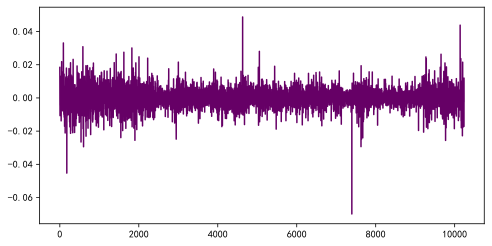

In [152]:
from itertools import chain 
# chain函数接受一系列可迭代对象并组合起来（如果是若干array就是串联）
# 使用chain.from_iterable将上述的并行结果转为可迭代对象
# ret_long就是每天的，每隔4096tick的data给串接起来了
ret_long = list(chain.from_iterable(result)) 
print(ts.adfuller(ret_long, maxlag=int(pow(len(ret_long)-1,(1/3))), regression='ct', autolag=None))
print(ts.kpss(ret_long, regression='c', lags=int(3*math.sqrt(len(ret_long))/13)))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(ret_long, color='#660066')

#### 可以看到，取4096个tick结果仍然是稳定的

In [104]:
# set trigger threshold and check 
# 设置触发器
threshold = 0.001
print(len(ret_long))
print(sum(np.array(ret_long) > threshold)) #高于临界值，做多
print(sum(np.array(ret_long) < -threshold)) #低于临界值，做空

10239
3858
3705


**下对比两种回测方法**
- 第一种，我们做return的一个predict，如果收益率的预测值大于阈值就设置pos为1，小于负的阈值就设置pos为-1，其他情况pos均为0。这种方法优点是反应很快，如果是日线的数据是很有用的，同时有很多其他的优点，比如不存在路径依赖，只涉及向量计算等等。相当于signal和position是一样的
- 第一种，适合低频交易，如果拿来回测高频，几乎是稳定亏钱：pos与signal设置相同，显然这样做开仓平仓太过频繁，稳定亏钱，因为predict的return稍有变化仓位就要发生改变，持仓时间过短而无法覆盖成本。而如果是日线策略那频率就可以得到控制，此时滑点手续费的影响不大，但如果是高频那影响极大
- **这个其实就是邢大的择时做的事情，比如signal产生了1或者0或者-1，那么position会在第二天（因为是T+1）时间内更改为对应的开多，平仓和做空**
- 对于低频的日线可能是可以的，还可以根据predicted return的具体大小决定仓位大小，threshold调整频率，越小频率会越高
- 多因子选股中低频适合这种回测方法，就是大于阈值就做多，低于负的阈值就做空，其余的空仓。我们之前的因子选股回测没有考虑择时，那如果这样做就是因子选股加择时，比如每周期不是根据因子的值去选股然后固定持有，而是考虑一个股票池，里面股票如果因子预测的收益是超过阈值的我们就做多……这样，相当于我们有一个监测池，当然可以是全体A股，然后不是每个固定周期都选股，而是根据预测的收益率决定是否被选，每只股票被选的时间也不一样

**日内交易必须收盘前平仓**

In [105]:
from collections import OrderedDict
# PNL代表损益，profit and loss
# 手续费先设置为印花税（千分之一）加上交易手续费（万分之一）
def get_daily_pnl_fast(date, product="rb", period=4096, threshold=0.001, tranct=1.1e-4, noise=0):
    with gzip.open(dire+"\\"+date, 'rb', compresslevel=1) as file_object:
        raw_data = file_object.read()
    ori_data = cPickle.loads(raw_data)
    data=ori_data[ori_data["good"]]
    n_bar = len(data)
    unit = np.std(data["ret"])
    np.random.seed(10)
    ##  we repeat the above code to get daily result
    ret_long = (data["ret"].rolling(period).sum()).dropna().reset_index(drop=True)
    ret_long = ret_long.append(pd.Series([0]*(len(data)-len(ret_long)))).reset_index(drop=True)
    signal = pd.Series([0] * n_bar)
    # 这里运用了next.ask和next.bid的数据，属于未来数据
    signal[(ret_long>threshold) & (np.array(data["next.ask"])>0)] = 1
    signal[(ret_long< -threshold) & (np.array(data["next.bid"])>0)] = -1
    position=signal
    position[0]=0
    # 日内交易必须收盘前平仓
    position[n_bar-1] = 0
    position[n_bar-2] = 0
    change_pos = position - position.shift(1)
    change_pos[0] = 0
    change_base = np.zeros(n_bar)
    change_buy = ((change_pos>0) & (np.array(data["next.ask"])>0))
    change_sell = ((change_pos<0) & (np.array(data["next.bid"])>0))
    change_base[change_buy] = (np.array(data["next.ask"])[change_buy])*(1+tranct)
    change_base[change_sell] = (np.array(data["next.bid"])[change_sell])*(1-tranct)
    change_buy = ((change_pos>0) & (np.array(data["next.ask"])==0))
    change_sell = ((change_pos<0) & (np.array(data["next.bid"])==0))
    change_base[change_buy] = (np.array(data["price"])[change_buy])*(1+tranct)
    change_base[change_sell] = (np.array(data["price"])[change_sell])*(1-tranct)
    final_pnl = -sum(change_base*change_pos)
    turnover = sum(change_base*abs(change_pos))
    num = sum((position!=0) & (change_pos!=0))
    hld_period = sum(position!=0)  
    ## finally we combine the statistics into a data frame
    #result = pd.DataFrame({"final.pnl": final_pnl, "turnover": turnover, "num": num, "hld.period": hld_period}, index=[0])
    #result = {"date": date, "final.pnl": final_pnl, "turnover": turnover, "num": num, "hld.period": hld_period}
    # 返回一个orderdict
    result = OrderedDict([("date", date), ("final.pnl", final_pnl), ("turnover", turnover), ("num", num), ("hld.period", hld_period)])
    return result

In [125]:
# 定义检查策略效果的函数
def get_performance(result, spread=1):
    aa = pd.DataFrame(result)
    aa.set_index("date", inplace=True)
    col_names = aa.columns
    row_names = aa.index
    stat = aa.values
    stat = np.array(np.rec.fromrecords(aa.values))
    np_names = aa.dtypes.index.tolist()
    stat.dtype.names = tuple([name for name in np_names])
    stat = pd.DataFrame(stat)
    pnl = stat["final.pnl"].cumsum()
    date_str = [n[0:8] for n in row_names]
    date_format = [pd.to_datetime(d) for d in date_str]
    fig, ax = plt.subplots(sharex=True, figsize=(8, 4))
    ax.set_title("Performance Back-testing")
    ax.set_xlabel("Date")
    ax.set_ylabel("PNL")
    plt.plot(date_format, pnl, color='r', linestyle='--')
    ax.grid(True)
    n_days = len(stat)
    num = stat["num"].mean()
    if num==0:
        return;
    if (stat["final.pnl"].std()==0):
        sharpe = 0
    else:
        sharpe = stat["final.pnl"].mean()/stat["final.pnl"].std()*math.sqrt(250)
    drawdown = max(pnl.cummax()-pnl)/pnl.iloc[-1]
    mar = 1/drawdown
    win_ratio = sum(stat["final.pnl"]>0)/n_days
   
    avg_pnl = sum(stat["final.pnl"])/sum(stat["num"])/spread
    hld_period = sum(stat["hld.period"])/sum(stat["num"])
    return OrderedDict([("sharpe", sharpe), ("drawdown", drawdown), ("mar", mar), ("win.ratio", win_ratio)
                        , ("num", num), ("avg.pnl", avg_pnl), ("hld.period", hld_period)])

In [106]:
import dask
from dask import compute, delayed #使用dask进行分布式并行计算
# 使用第一天为例进行回测，pnl都是负值
get_daily_pnl_fast(all_dates[0], product="rb", period=4096, threshold=0.001, tranct=1.1e-4)

OrderedDict([('date', '20170103.pkl'),
             ('final.pnl', -142.85490000006712),
             ('turnover', 1189590.0013199989),
             ('num', 206),
             ('hld.period', 31917)])

In [107]:
%%time
import functools
# 使用全部的天数
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_daily_pnl_fast, product="rb", period=4096, threshold=0.001, tranct=1.1e-4, noise=0)
    result = compute([delayed(f_par)(date) for date in all_dates])[0]

Wall time: 1min 20s


,sharpe,drawdown,mar,win.ratio,num,avg.pnl,hld.period
0,-6.62868,-0.999604,-1.000397,0.014111,142.839135,-2.373222,180.750063


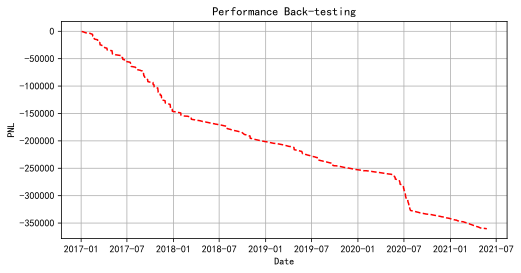

In [126]:
pd.DataFrame(get_performance(result, 1), index=[0])

结果很差，持仓时间太多，才一百多跳。换一个threshold再试一次

In [129]:
%%time
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_daily_pnl_fast, product="rb", period=4086, threshold=0.01, tranct=1.1e-4, noise=0)
    result_2 = compute([delayed(f_par)(date) for date in all_dates])[0]

Wall time: 1min 12s


,sharpe,drawdown,mar,win.ratio,num,avg.pnl,hld.period
0,-1.668104,-0.997929,-1.002075,0.106303,12.342427,-2.061788,101.001448


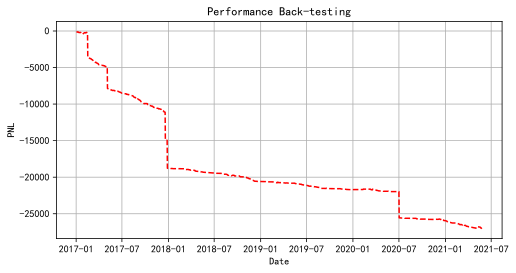

In [130]:
pd.DataFrame(get_performance(result_2), index=[0])

In [127]:
%%time
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_daily_pnl_fast, product="rb", period=4096, threshold=0.02, tranct=1.1e-4, noise=0)
    result_3 = compute([delayed(f_par)(date) for date in all_dates])[0]

Wall time: 1min 15s


,sharpe,drawdown,mar,win.ratio,num,avg.pnl,hld.period
0,-0.443265,-1.95533,-0.511423,0.0254,1.065851,-0.302441,81.768756


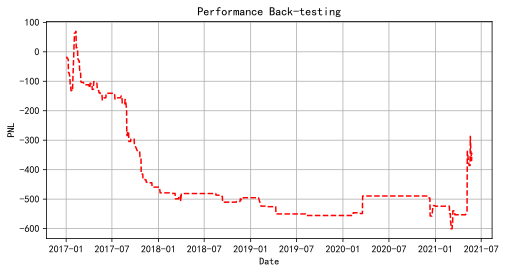

In [128]:
pd.DataFrame(get_performance(result_3, 1), index=[0])

- 第二种回测方法是路径依赖的，**无法向量化计算**，定义一个signal，如果预测收益率大于threshold，那么signal设为1，小于负的threshold，那么signal为-1，其他情况signal为0。然后，如果sig=1，pos=1; sig=-1, pos=-1, sig=0的话，pos不会清仓，而是维持原来的仓位。相当于永远都在持仓。
- 下使用第二种回测方法，使得持仓的时间长一些。
- 之前的回测中，我们平仓太快了。有可能平仓过快过于频繁，无法cover中间的手续费（transaction cost）。现在使用另一种更适合高频交易的回测方法，使之持仓的时间长一些，不至于持仓时间太短，被手续费拖了后腿。
- 回测很好因为使用了未来数据next.ask和next.bid，只是说明这个回测框架是有效的，加上noise之后就没那么好，加上threshold就可以过滤noise。如果把代码里的next.ask和next.bid更换为当前的ask和bid，那效果直接寄了。

**注意我们做的是intraday trading，日内交易所以收盘前要平仓**

In [131]:
from collections import OrderedDict
# 这里持仓默认为两千多跳，也就是一个小时左右了，结果好了很多，但是这个回测使用了未来数据next.ask和next.bid
# 无法向量化计算，只能尽量去优化代码
def get_daily_pnl(date, product="rb", period=2000, threshold=0.001, tranct=1.1e-4, noise=0):
    with gzip.open(dire+"\\"+date, 'rb', compresslevel=1) as file_object:
        raw_data = file_object.read()
    data = cPickle.loads(raw_data)
    data = data[data["good"]].reset_index(drop=True)
    n_bar = len(data)
    unit = np.std(data["ret"])
    np.random.seed(10)
    noise_ret = np.random.normal(scale=unit*noise, size=n_bar)
    ##  we repeat the above code to get daily result
    ret_2000 = (data["ret"].rolling(period).sum()).dropna().reset_index(drop=True)
    ret_2000 = ret_2000.append(pd.Series([0]*(len(data)-len(ret_2000)))).reset_index(drop=True) + noise_ret
    signal = pd.Series([0] * n_bar)
    signal[ret_2000 > threshold] = 1
    signal[ret_2000 < -threshold] = -1
    position_pos = pd.Series([np.nan] * n_bar)
    position_pos[0] = 0
    # next_bid和next_ask是未来数据，我们直接用了未来数据作为预测值然后回测，显然效果会很好
    position_pos[(signal==1) & (data["next.ask"]>0) & (data["next.bid"]>0)] = 1
    position_pos[(ret_2000< -threshold) & (data["next.bid"]>0)] = 0
    # 这一行ffill可以大大加快回测的速度！！
    position_pos.ffill(inplace=True)
    position_neg = pd.Series([np.nan] * n_bar)
    position_neg[0] = 0
    position_neg[(signal==-1) & (data["next.ask"]>0) & (data["next.bid"]>0)] = -1
    position_neg[(ret_2000> threshold) & (data["next.ask"]>0)] = 0
    position_neg.ffill(inplace=True)
    position = position_pos + position_neg
    # 初始仓位为0
    position[0]=0
    # 收盘前平仓！
    position[n_bar-1] = 0
    position[n_bar-2] = 0
    change_pos = position - position.shift(1)
    change_pos[0] = 0
    change_base = pd.Series([0] * n_bar)
    change_buy = change_pos>0
    change_sell = change_pos<0
    change_base[change_buy & data["next.ask"]>0] = (data["next.ask"][change_buy & data["next.ask"]>0])*(1+tranct)
    change_base[change_buy & data["next.ask"]==0] = (data["price"][change_buy & data["next.ask"]==0])*(1+tranct)
    change_base[change_sell & data["next.bid"]>0] = (data["next.bid"][change_sell & data["next.bid"]>0])*(1-tranct)
    change_base[change_sell & data["next.bid"]==0] = (data["price"][change_sell & data["next.bid"]==0])*(1-tranct)
    
    final_pnl = -sum(change_base*change_pos)
    turnover = sum(change_base*abs(change_pos))
    num = sum((position!=0) & (change_pos!=0))
    hld_period = sum(position!=0)
  
    ## finally we combine the statistics into a data frame
    #result = pd.DataFrame({"final.pnl": final_pnl, "turnover": turnover, "num": num, "hld.period": hld_period}, index=[0])
    #result = {"date": date, "final.pnl": final_pnl, "turnover": turnover, "num": num, "hld.period": hld_period}
    result = OrderedDict([("date", date), ("final.pnl", final_pnl), ("turnover", turnover), ("num", num), ("hld.period", hld_period)])
    return result

In [132]:
%%time
import functools
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_daily_pnl, product="rb", period=4096, threshold=0.001, tranct=1.1e-4, noise=0)
    result_4 = compute([delayed(f_par)(date) for date in all_dates])[0]

Wall time: 1min 36s


,sharpe,drawdown,mar,win.ratio,num,avg.pnl,hld.period
0,31.930284,0.0,inf,1.0,14.042333,8.898599,2825.744825


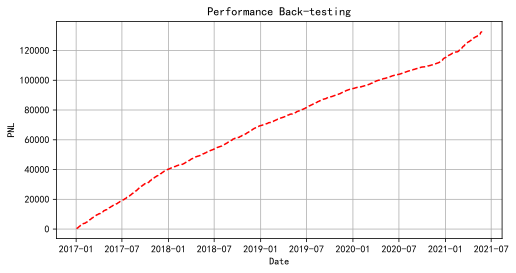

In [133]:
pd.DataFrame(get_performance(result_4,1), index=[0])

#### 现在添加一些noise，看看结果如何

In [134]:
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_daily_pnl, product="rb", period=4096, threshold=0.002, tranct=1.1e-4, noise=5)
    result_5 = compute([delayed(f_par)(date) for date in all_dates])[0]

,sharpe,drawdown,mar,win.ratio,num,avg.pnl,hld.period
0,22.618474,0.014856,67.311583,0.999059,13.5381,9.246082,2923.871517


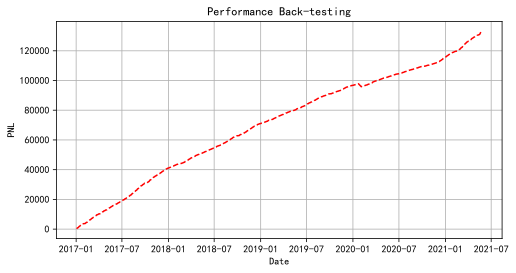

In [135]:
pd.DataFrame(get_performance(result_5,1), index=[0])

#### 可以看出，添加了一些noise，结果仍然不错。
#### 这一种回测方法更适合高频交易，我们在里面使用了未来函数，所以实际应用中不现实，不能拿来直接做交易，因为比如我们回测一直在用下一期的对数收益率。就像之前的股票策略一样，回测有一列数据是下周期收益率，显然实战中并不能使用，因此上面这个逆天的曲线也根本不可能实现。
#### 后续策略编写会使用这种回测方法，同时会避免所有的未来函数。一旦避免了未来函数，效果自然就会差很多，但是更加贴近实际。这门课的目标就是，用历史的数据，预测未来的收益，而同时也能赚钱。